<a href="https://colab.research.google.com/github/filipabramowicz/ML_AI_course/blob/main/lab_10_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's import all that's necessary:

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
#from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import itertools

Install keras-tuner:

In [ ]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Let's load and prepare the data:

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(class_names)

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

Define the builder function with number of dense layers as hyperparameter:

In [ ]:
def model_builder(hp):
  model = keras.Sequential()
  
  model.add(Conv2D(32, (3, 3), activation='relu',  padding='same', input_shape=(32, 32, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(64, (3, 3), activation='relu',  padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))

  model.add(Flatten())

  for i in range(hp.Int("num_layers", 1, 5)):
    model.add(Dense(128, activation='tanh'))

  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(10, activation='softmax'))

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  return(model)

In [ ]:
import keras_tuner as kt
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=8,
                     overwrite=True, #!!!!
                     directory='my_Hyperband',
                     project_name='CIFAR',
                     seed=42)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tensorboard_logs = keras.callbacks.TensorBoard("/tmp/tb_logs")

tuner.search_space_summary()

Search space summary
Default search space size: 1
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}


In [ ]:
tuner.search(X_train, y_train, epochs=5, validation_split=0.2, batch_size=62, callbacks=[stop_early])

Trial 7 Complete [00h 00m 26s]
val_accuracy: 0.7121000289916992

Best val_accuracy So Far: 0.7121999859809875
Total elapsed time: 00h 03m 22s


Let's check the summary/nest results:

In [ ]:
tuner.results_summary(num_trials=3)

Results summary
Results in my_Hyperband/CIFAR
Showing 3 best trials
Objective(name="val_accuracy", direction="max")

Trial 0005 summary
Hyperparameters:
num_layers: 2
tuner/epochs: 8
tuner/initial_epoch: 3
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0003
Score: 0.7121999859809875

Trial 0006 summary
Hyperparameters:
num_layers: 3
tuner/epochs: 8
tuner/initial_epoch: 3
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0002
Score: 0.7121000289916992

Trial 0003 summary
Hyperparameters:
num_layers: 2
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.6647999882698059


Let's use best parameters to build the model:

In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

Let's validate the model but without augmentation yet:

In [ ]:
history_no_aug = model.fit(X_train, y_train, epochs=16, batch_size=64, validation_data=(X_test, y_test))
loss_no_aug, acc_no_aug = model.evaluate(X_test,  y_test)

Epoch 1/16
782/782 [==============================] - 8s 7ms/step - loss: 1.4824 - accuracy: 0.4585 - val_loss: 1.1840 - val_accuracy: 0.5696
Epoch 2/16
782/782 [==============================] - 4s 6ms/step - loss: 1.1357 - accuracy: 0.5968 - val_loss: 1.0375 - val_accuracy: 0.6366
Epoch 3/16
782/782 [==============================] - 5s 6ms/step - loss: 1.0220 - accuracy: 0.6397 - val_loss: 0.9507 - val_accuracy: 0.6658
Epoch 4/16
782/782 [==============================] - 4s 6ms/step - loss: 0.9449 - accuracy: 0.6678 - val_loss: 0.9050 - val_accuracy: 0.6852
Epoch 5/16
782/782 [==============================] - 5s 6ms/step - loss: 0.8851 - accuracy: 0.6885 - val_loss: 0.9078 - val_accuracy: 0.6820
Epoch 6/16
782/782 [==============================] - 5s 7ms/step - loss: 0.8432 - accuracy: 0.7015 - val_loss: 0.8643 - val_accuracy: 0.7014
Epoch 7/16
782/782 [==============================] - 4s 6ms/step - loss: 0.7983 - accuracy: 0.7210 - val_loss: 0.8701 - val_accuracy: 0.6976
Epoch 

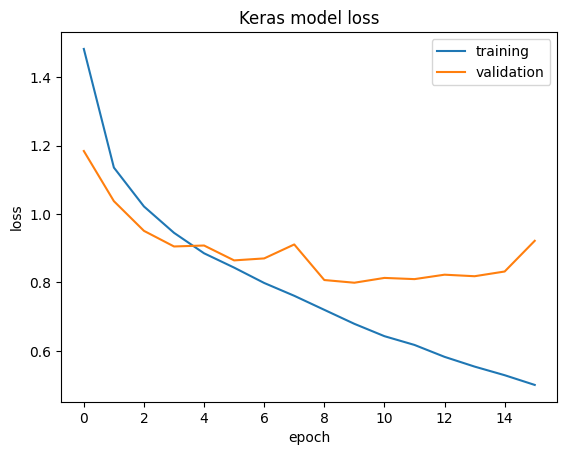

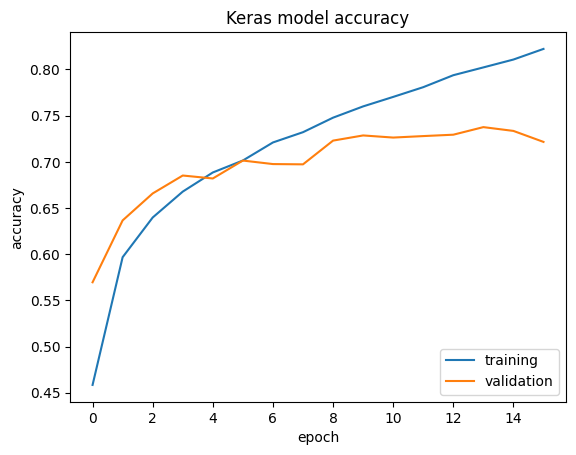

0.7215999960899353


In [ ]:
# Visualize History for Loss.
plt.title('Keras model loss')
plt.plot(history_no_aug.history['loss'])
plt.plot(history_no_aug.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# Visualize History for Accuracy.
plt.title('Keras model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history_no_aug.history['accuracy'])
plt.plot(history_no_aug.history['val_accuracy'])
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

print(acc_no_aug)

Let's add some augmentation:

In [ ]:
datagen = ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=3/32,
    height_shift_range=3/32,
    )

In [ ]:
history_aug = model.fit(datagen.flow(X_train, y_train, batch_size=64), epochs=16, validation_data=(X_test, y_test))
loss_aug, acc_aug = model.evaluate(X_test,  y_test)


Epoch 1/16
782/782 [==============================] - 32s 40ms/step - loss: 0.9303 - accuracy: 0.6773 - val_loss: 0.7912 - val_accuracy: 0.7274
Epoch 2/16
782/782 [==============================] - 28s 36ms/step - loss: 0.8721 - accuracy: 0.6952 - val_loss: 0.8307 - val_accuracy: 0.7134
Epoch 3/16
782/782 [==============================] - 27s 34ms/step - loss: 0.8536 - accuracy: 0.7015 - val_loss: 0.7593 - val_accuracy: 0.7395
Epoch 4/16
782/782 [==============================] - 28s 36ms/step - loss: 0.8351 - accuracy: 0.7069 - val_loss: 0.7760 - val_accuracy: 0.7328
Epoch 5/16
782/782 [==============================] - 28s 36ms/step - loss: 0.8236 - accuracy: 0.7112 - val_loss: 0.8050 - val_accuracy: 0.7265
Epoch 6/16
782/782 [==============================] - 27s 35ms/step - loss: 0.8046 - accuracy: 0.7185 - val_loss: 0.7747 - val_accuracy: 0.7334
Epoch 7/16
782/782 [==============================] - 27s 35ms/step - loss: 0.7966 - accuracy: 0.7222 - val_loss: 0.7767 - val_accuracy:

Let's visualize the results:

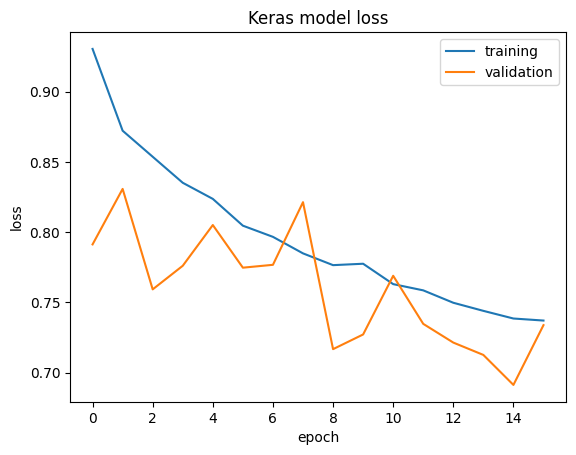

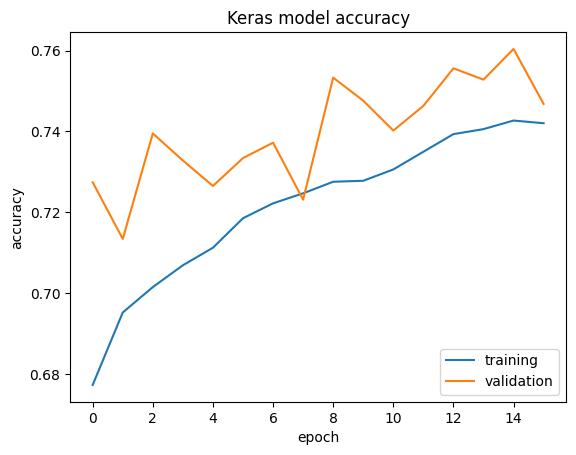

0.7468000054359436


In [ ]:
# Visualize History for Loss.
plt.title('Keras model loss')
plt.plot(history_aug.history['loss'])
plt.plot(history_aug.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# Visualize History for Accuracy.
plt.title('Keras model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history_aug.history['accuracy'])
plt.plot(history_aug.history['val_accuracy'])
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

print(acc_aug)